# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_density_and_log"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_density_and_log/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.007327,0.012471,0.587574,0.556839,0.278419,random.pheno988
1,LV2,0.017015,0.012465,1.365051,0.172285,0.086142,random.pheno988
2,LV3,-0.009563,0.012493,-0.765507,0.443998,0.778001,random.pheno988
3,LV4,-0.012907,0.012510,-1.031767,0.302220,0.848890,random.pheno988
4,LV5,0.002468,0.012471,0.197917,0.843117,0.421558,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.06005167173252279

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.005,0.034,0.061
1,LV10,0.013,0.051,0.085
2,LV100,0.018,0.052,0.098
3,LV101,0.018,0.053,0.096
4,LV102,0.011,0.057,0.101


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016536,0.060052,0.108073
std,0.007942,0.015641,0.021968
min,0.002000,0.014000,0.032000
25%,0.012000,0.050000,0.094000
50%,0.015000,0.059000,0.108000
75%,0.020000,0.069000,0.121000
max,0.104000,0.158000,0.219000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(71, 4)

,lv,1,5,10
313,LV381,0.015,0.049,0.102
528,LV575,0.010,0.049,0.090
514,LV562,0.011,0.049,0.096
941,LV947,0.012,0.049,0.088
462,LV515,0.017,0.049,0.096
801,LV820,0.015,0.049,0.097
388,LV449,0.014,0.049,0.093
386,LV447,0.012,0.049,0.093
861,LV875,0.012,0.049,0.088
624,LV661,0.010,0.049,0.114


,lv,1,5,10
585,LV626,0.014,0.051,0.106
50,LV144,0.012,0.051,0.107
61,LV154,0.011,0.051,0.094
109,LV198,0.013,0.051,0.114
171,LV253,0.013,0.051,0.099
220,LV298,0.010,0.051,0.089
235,LV310,0.020,0.051,0.099
240,LV315,0.022,0.051,0.099
311,LV38,0.012,0.051,0.089
334,LV40,0.012,0.051,0.106


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(446, 4)

,lv,1,5,10
663,LV697,0.035,0.095,0.158
199,LV279,0.027,0.095,0.151
796,LV816,0.028,0.097,0.159
213,LV291,0.042,0.098,0.141
28,LV124,0.036,0.101,0.150
382,LV443,0.042,0.101,0.135
142,LV227,0.043,0.103,0.146
99,LV189,0.033,0.105,0.162
557,LV600,0.034,0.105,0.181
471,LV523,0.033,0.105,0.172


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.005488,0.012460,0.440440,0.659633,0.329817,random.pheno988
1031,LV45,0.001013,0.012461,0.081269,0.935231,0.467615,random.pheno589
2018,LV45,0.000068,0.012461,0.005472,0.995634,0.497817,random.pheno385
3005,LV45,0.006991,0.012459,0.561169,0.574702,0.287351,random.pheno5
3992,LV45,-0.009046,0.012460,-0.725991,0.467871,0.766065,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.104

In [31]:
show_prop(results, 0.05)

0.158

In [32]:
show_prop(results, 0.10)

0.219

In [33]:
show_prop(results, 0.15)

0.265

In [34]:
show_prop(results, 0.20)

0.291

### QQplot

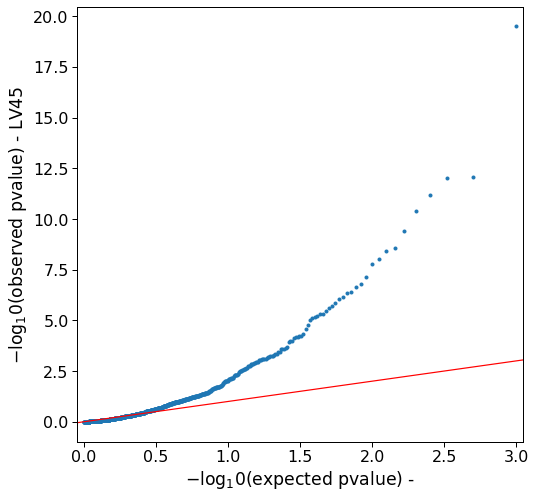

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.004063,0.012464,0.325994,0.744440,0.372220,random.pheno988
1220,LV234,-0.001158,0.012464,-0.092907,0.925980,0.537010,random.pheno589
2207,LV234,0.002348,0.012464,0.188384,0.850581,0.425291,random.pheno385
3194,LV234,0.013121,0.012461,1.052942,0.292407,0.146204,random.pheno5
4181,LV234,0.011732,0.012463,0.941342,0.346565,0.173283,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.085

In [42]:
show_prop(results, 0.05)

0.157

In [43]:
show_prop(results, 0.10)

0.209

In [44]:
show_prop(results, 0.15)

0.243

In [45]:
show_prop(results, 0.20)

0.284

### QQplot

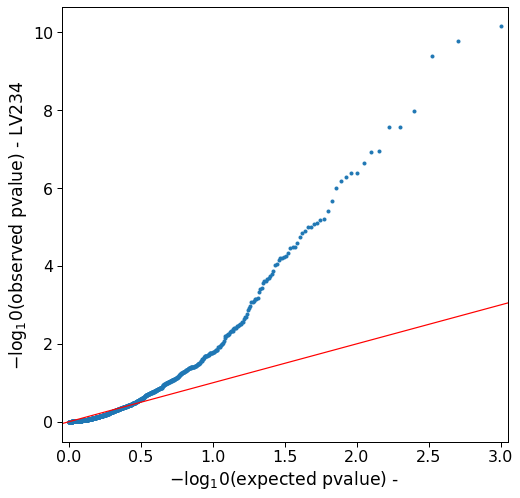

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.004553,0.012464,-0.365286,0.714910,0.642545,random.pheno988
1833,LV847,0.001605,0.012465,0.128800,0.897520,0.448760,random.pheno589
2820,LV847,-0.003208,0.012464,-0.257404,0.796875,0.601562,random.pheno385
3807,LV847,0.008287,0.012462,0.664938,0.506114,0.253057,random.pheno5
4794,LV847,0.014520,0.012463,1.165037,0.244047,0.122024,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.09

In [53]:
show_prop(results, 0.05)

0.14

In [54]:
show_prop(results, 0.10)

0.193

In [55]:
show_prop(results, 0.15)

0.225

In [56]:
show_prop(results, 0.20)

0.263

### QQplot

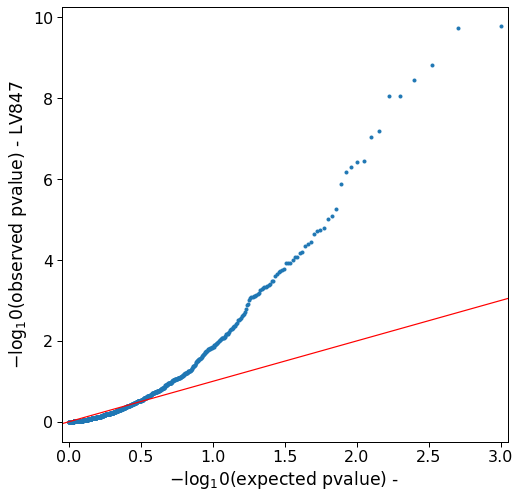

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.024467,0.012460,-1.963631,0.049616,0.975192,random.pheno988
1096,LV110,0.000944,0.012464,0.075715,0.939648,0.469824,random.pheno589
2083,LV110,-0.005004,0.012464,-0.401446,0.688105,0.655947,random.pheno385
3070,LV110,-0.005935,0.012462,-0.476251,0.633912,0.683044,random.pheno5
4057,LV110,0.009780,0.012463,0.784726,0.432643,0.216322,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.077

In [64]:
show_prop(results, 0.05)

0.126

In [65]:
show_prop(results, 0.10)

0.173

In [66]:
show_prop(results, 0.15)

0.212

In [67]:
show_prop(results, 0.20)

0.243

### QQplot

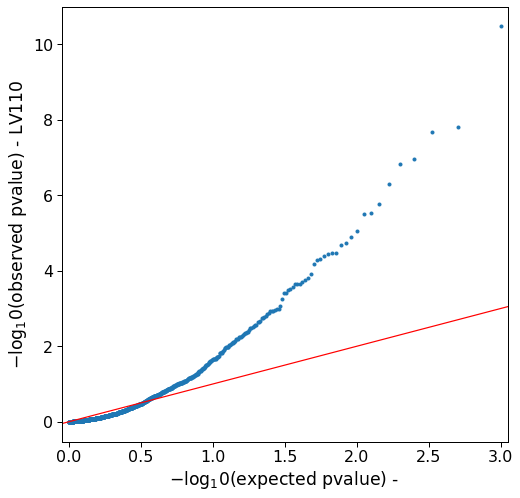

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.012457,0.012460,0.999761,0.317464,0.158732,random.pheno988
1755,LV769,0.001414,0.012461,0.113501,0.909637,0.454818,random.pheno589
2742,LV769,0.001906,0.012461,0.152919,0.878467,0.439234,random.pheno385
3729,LV769,-0.021402,0.012457,-1.718085,0.085829,0.957085,random.pheno5
4716,LV769,-0.019109,0.012459,-1.533770,0.125135,0.937432,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.037

In [75]:
show_prop(results, 0.05)

0.119

In [76]:
show_prop(results, 0.10)

0.198

In [77]:
show_prop(results, 0.15)

0.25

In [78]:
show_prop(results, 0.20)

0.303

### QQplot

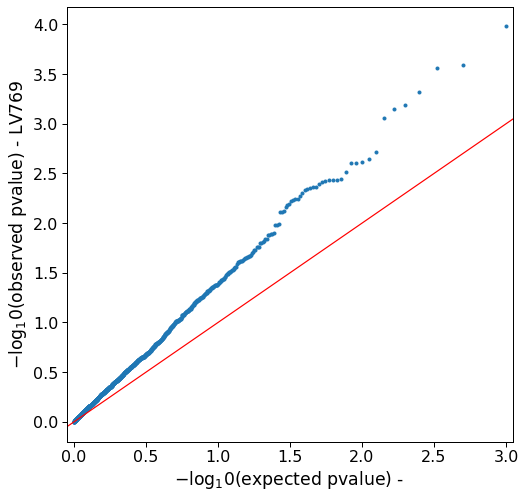

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.011573,0.012477,0.927525,0.353689,0.176844,random.pheno988
1786,LV800,0.002900,0.012478,0.232394,0.816239,0.408120,random.pheno589
2773,LV800,-0.010829,0.012477,-0.867862,0.385502,0.807249,random.pheno385
3760,LV800,-0.022842,0.012473,-1.831268,0.067107,0.966447,random.pheno5
4747,LV800,-0.009599,0.012478,-0.769280,0.441755,0.779122,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.047

In [86]:
show_prop(results, 0.05)

0.111

In [87]:
show_prop(results, 0.10)

0.174

In [88]:
show_prop(results, 0.15)

0.21

In [89]:
show_prop(results, 0.20)

0.252

### QQplot

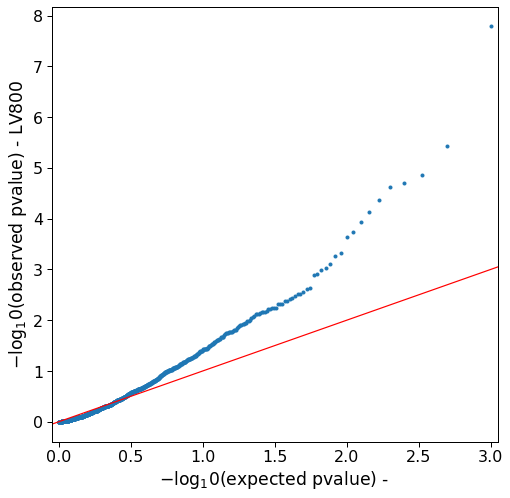

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
313,LV381,0.015,0.049,0.102
528,LV575,0.010,0.049,0.090
514,LV562,0.011,0.049,0.096
941,LV947,0.012,0.049,0.088
462,LV515,0.017,0.049,0.096
801,LV820,0.015,0.049,0.097
388,LV449,0.014,0.049,0.093
386,LV447,0.012,0.049,0.093
861,LV875,0.012,0.049,0.088
624,LV661,0.010,0.049,0.114


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.010195,0.012465,-0.817897,0.413446,0.793277,random.pheno988
1398,LV412,-0.016124,0.012464,-1.293655,0.195831,0.902085,random.pheno589
2385,LV412,0.019309,0.012463,1.549258,0.121369,0.060684,random.pheno385
3372,LV412,0.009165,0.012464,0.735339,0.462160,0.231080,random.pheno5
4359,LV412,0.009914,0.012465,0.795369,0.426428,0.213214,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.009

In [99]:
show_prop(results, 0.05)

0.048

In [100]:
show_prop(results, 0.10)

0.101

In [101]:
show_prop(results, 0.15)

0.139

In [102]:
show_prop(results, 0.20)

0.178

### QQplot

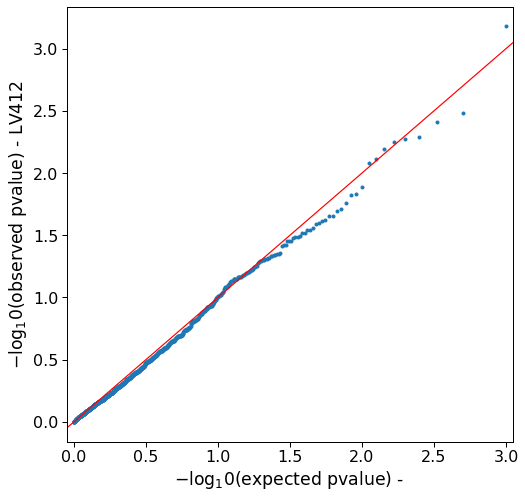

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.020412,0.012470,-1.636877,0.101705,0.949148,random.pheno988
1043,LV57,0.024262,0.012470,1.945700,0.051734,0.025867,random.pheno589
2030,LV57,0.015826,0.012472,1.268964,0.204500,0.102250,random.pheno385
3017,LV57,-0.002886,0.012471,-0.231396,0.817014,0.591493,random.pheno5
4004,LV57,0.014244,0.012472,1.142099,0.253455,0.126728,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.015

In [110]:
show_prop(results, 0.05)

0.048

In [111]:
show_prop(results, 0.10)

0.096

In [112]:
show_prop(results, 0.15)

0.14

In [113]:
show_prop(results, 0.20)

0.19

### QQplot

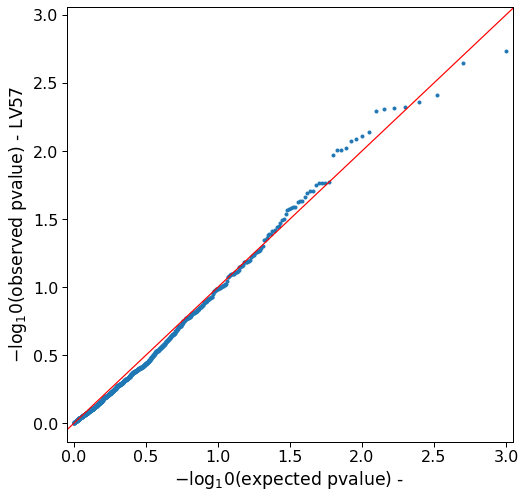

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.008292,0.012466,-0.665185,0.505956,0.747022,random.pheno988
1633,LV647,0.000142,0.012467,0.011360,0.990936,0.495468,random.pheno589
2620,LV647,-0.000580,0.012467,-0.046542,0.962879,0.518560,random.pheno385
3607,LV647,0.004563,0.012465,0.366052,0.714338,0.357169,random.pheno5
4594,LV647,0.004626,0.012467,0.371092,0.710581,0.355290,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.01

In [121]:
show_prop(results, 0.05)

0.051

In [122]:
show_prop(results, 0.10)

0.085

In [123]:
show_prop(results, 0.15)

0.138

In [124]:
show_prop(results, 0.20)

0.176

### QQplot

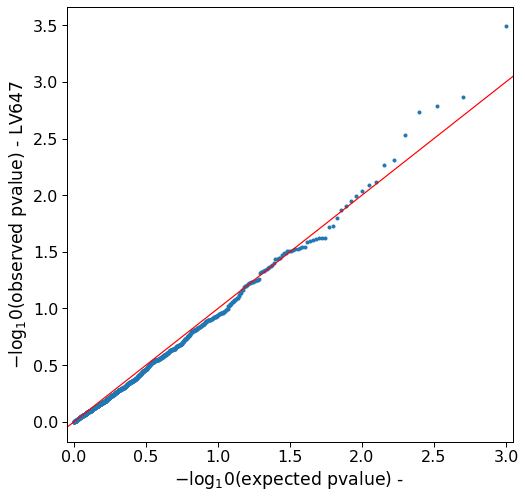

In [125]:
qqplot_unif(results)